In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import the daily USDINR data
df = pd.read_csv('daily_usdinr.csv')

# Display initial info
print("Column names:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Use first two columns (assuming date and usdinr)
df = df.iloc[:, [0, 1]]
df.columns = ['date', 'usdinr']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Sort by date in ascending order
df = df.sort_index()

# Calculate returns as percentage change
df['returns'] = df['usdinr'].pct_change()

print(f"\nData range: {df.index[0]} to {df.index[-1]}")
print(f"Total observations: {len(df)}")
print(f"\nBasic statistics:")
print(df[['usdinr', 'returns']].describe())

Column names: ['Date', 'USDINR']

First few rows:
         Date   USDINR
0  11/21/2025  89.4088
1  11/20/2025  88.7075
2  11/19/2025  88.5875
3  11/18/2025  88.6113
4  11/17/2025  88.6387

Data range: 1998-12-31 00:00:00 to 2025-11-21 00:00:00
Total observations: 6671

Basic statistics:
            usdinr      returns
count  6671.000000  6670.000000
mean     58.012745     0.000118
std      14.401494     0.003661
min      39.265000    -0.032682
25%      45.505000    -0.001302
50%      51.467500     0.000000
75%      69.825000     0.001349
max      89.408800     0.040112


In [2]:
# Volatility Model - Calculate how many standard deviations each daily move is

# Calculate rolling standard deviation (30-day window)
rolling_window = 30
df['rolling_std'] = df['returns'].rolling(window=rolling_window).std()

# Calculate z-score (number of standard deviations from mean)
df['z_score'] = df['returns'] / df['rolling_std']

# Display statistics
print("Volatility Statistics:")
print(f"Mean daily return: {df['returns'].mean():.6f}")
print(f"Overall std dev of returns: {df['returns'].std():.6f}")
print(f"\nZ-Score Statistics:")
print(df['z_score'].describe())

# Identify extreme moves (beyond ±2 standard deviations)
extreme_moves = df[np.abs(df['z_score']) > 2].copy()
print(f"\n\nExtreme moves (>2 std dev): {len(extreme_moves)} out of {len(df.dropna())} days ({len(extreme_moves)/len(df.dropna())*100:.1f}%)")
print("\nMost extreme moves:")
print(extreme_moves[['usdinr', 'returns', 'rolling_std', 'z_score']].nlargest(10, 'z_score', keep='all'))

Volatility Statistics:
Mean daily return: 0.000118
Overall std dev of returns: 0.003661

Z-Score Statistics:
count    6641.000000
mean        0.033785
std         1.031308
min        -4.491697
25%        -0.554286
50%         0.000000
75%         0.568351
max         5.408769
Name: z_score, dtype: float64


Extreme moves (>2 std dev): 424 out of 6641 days (6.4%)

Most extreme moves:
             usdinr   returns  rolling_std   z_score
date                                                
2000-05-10  44.0500  0.008124     0.001502  5.408769
2021-02-26  73.4650  0.014341     0.002905  4.936060
2025-01-13  86.5813  0.007066     0.001497  4.720614
2001-09-14  47.8150  0.005362     0.001147  4.676400
2007-03-05  44.6575  0.008298     0.001896  4.376862
2007-08-16  41.2750  0.012697     0.002935  4.325500
2006-04-12  45.1900  0.007918     0.001844  4.294556
2001-09-07  47.2650  0.001695     0.000396  4.277269
2018-08-13  69.9337  0.015961     0.003771  4.232525
2019-08-05  70.7325  0.016162  

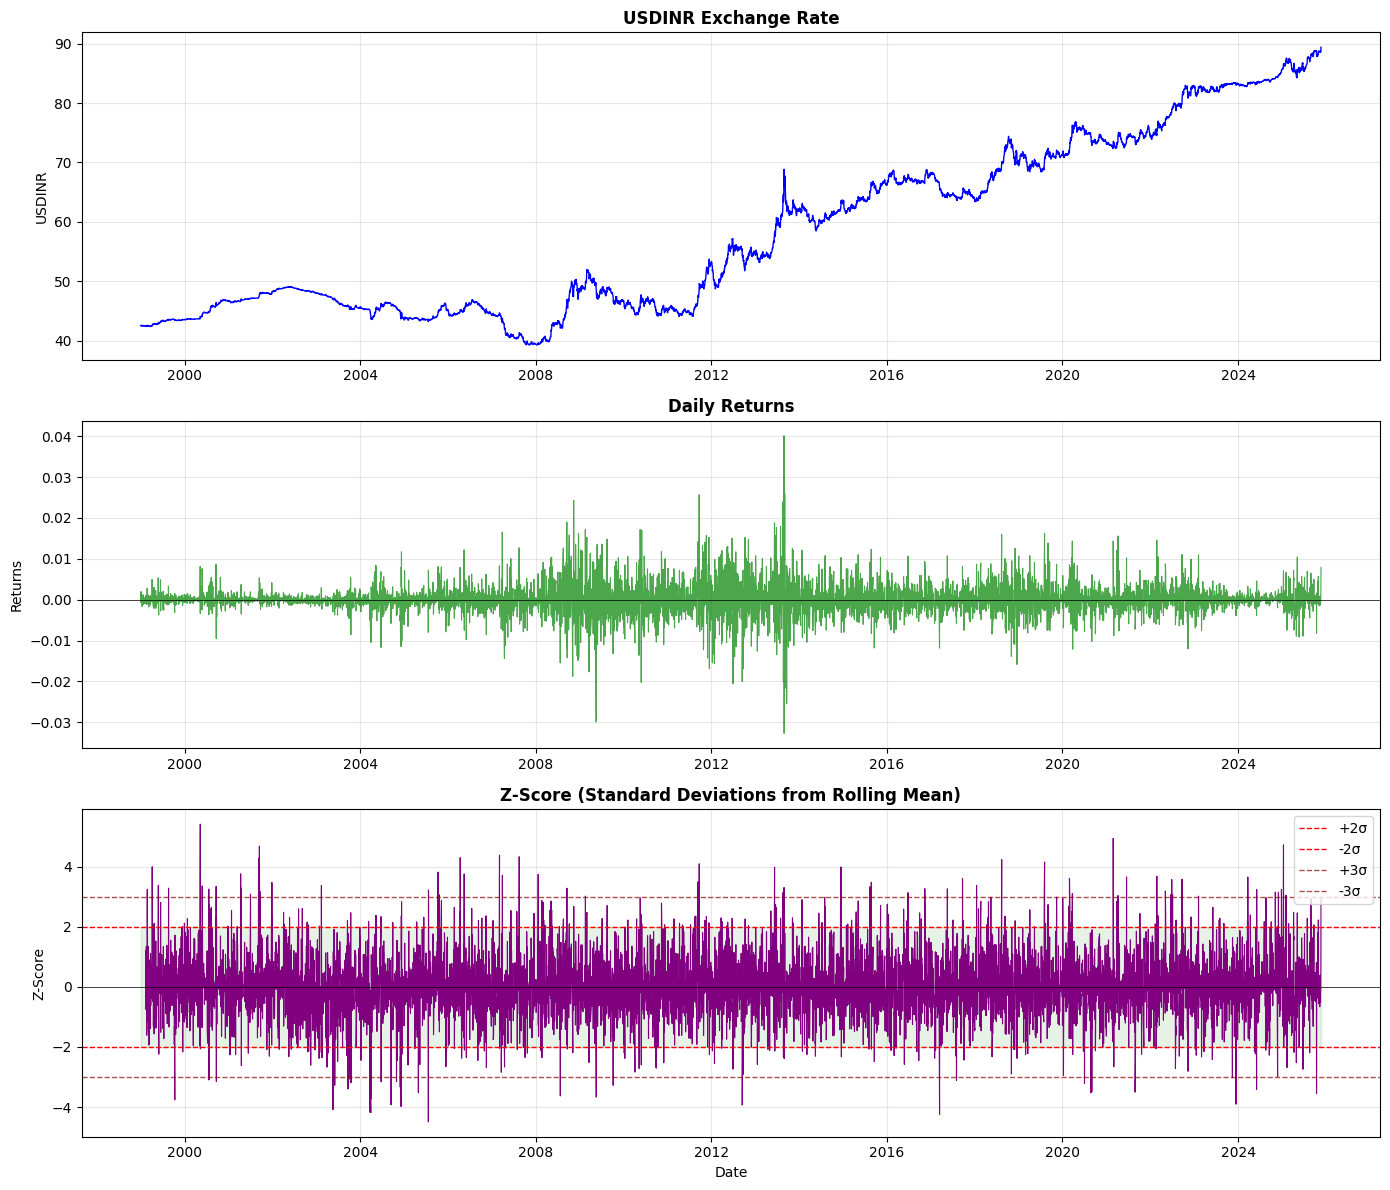

In [3]:
# Plot returns and z-scores over time
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: USDINR price
axes[0].plot(df.index, df['usdinr'], color='blue', linewidth=1)
axes[0].set_title('USDINR Exchange Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('USDINR')
axes[0].grid(True, alpha=0.3)

# Plot 2: Daily returns
axes[1].plot(df.index, df['returns'], color='green', linewidth=0.8, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_title('Daily Returns', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Returns')
axes[1].grid(True, alpha=0.3)

# Plot 3: Z-scores with standard deviation bands
axes[2].plot(df.index, df['z_score'], color='purple', linewidth=0.8)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].axhline(y=2, color='red', linestyle='--', linewidth=1, label='+2σ')
axes[2].axhline(y=-2, color='red', linestyle='--', linewidth=1, label='-2σ')
axes[2].axhline(y=3, color='darkred', linestyle='--', linewidth=1, label='+3σ', alpha=0.7)
axes[2].axhline(y=-3, color='darkred', linestyle='--', linewidth=1, label='-3σ', alpha=0.7)
axes[2].fill_between(df.index, -2, 2, color='green', alpha=0.1)
axes[2].set_title('Z-Score (Standard Deviations from Rolling Mean)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Z-Score')
axes[2].set_xlabel('Date')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

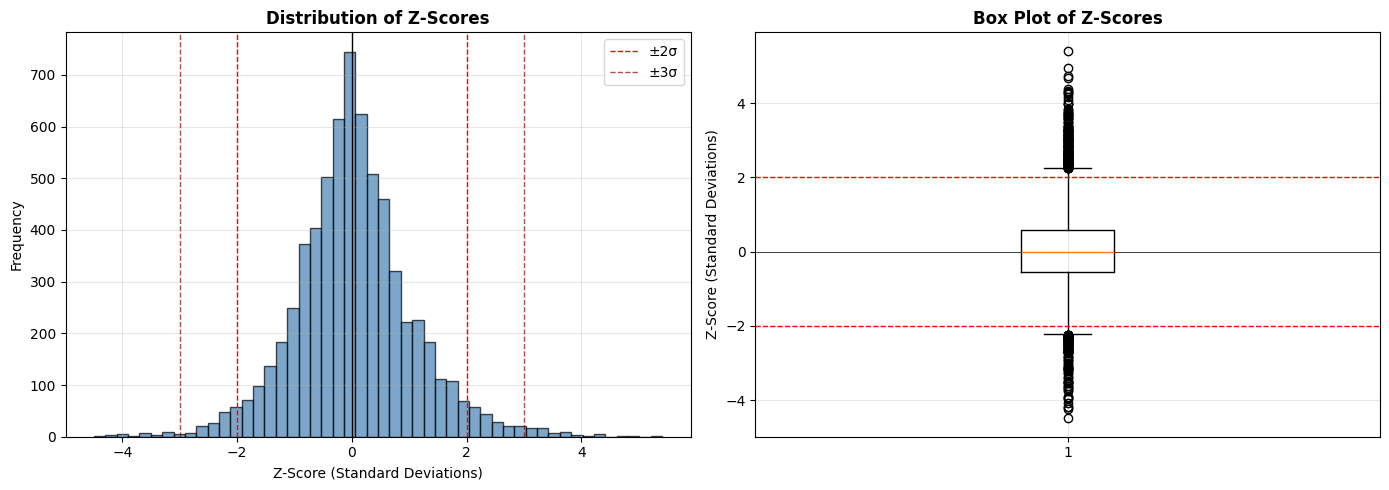


Percentage of moves by standard deviation threshold:
Moves > 1σ: 1814 (27.32%)
Moves > 1.5σ: 861 (12.96%)
Moves > 2σ: 424 (6.38%)
Moves > 2.5σ: 186 (2.80%)
Moves > 3σ: 101 (1.52%)


In [4]:
# Distribution of z-scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of z-scores
axes[0].hist(df['z_score'].dropna(), bins=50, edgecolor='black', color='steelblue', alpha=0.7)
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[0].axvline(x=2, color='red', linestyle='--', linewidth=1, label='±2σ')
axes[0].axvline(x=-2, color='red', linestyle='--', linewidth=1)
axes[0].axvline(x=3, color='darkred', linestyle='--', linewidth=1, label='±3σ', alpha=0.7)
axes[0].axvline(x=-3, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
axes[0].set_title('Distribution of Z-Scores', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Z-Score (Standard Deviations)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot of z-scores
axes[1].boxplot(df['z_score'].dropna(), vert=True)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].axhline(y=2, color='red', linestyle='--', linewidth=1, label='±2σ')
axes[1].axhline(y=-2, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Box Plot of Z-Scores', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Z-Score (Standard Deviations)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Percentage of moves by standard deviation threshold
print("\nPercentage of moves by standard deviation threshold:")
total_moves = len(df['z_score'].dropna())
for threshold in [1, 1.5, 2, 2.5, 3]:
    count = (np.abs(df['z_score']) > threshold).sum()
    pct = (count / total_moves) * 100
    print(f"Moves > {threshold}σ: {count} ({pct:.2f}%)")

In [5]:
# Analyze the latest move
latest_date = df.index[-1]
latest_data = df.iloc[-1]

print(f"Latest Move Analysis (as of {latest_date.strftime('%Y-%m-%d')}):")
print("="*60)
print(f"\nUSDINR Level: {latest_data['usdinr']:.4f}")
print(f"Daily Return: {latest_data['returns']*100:.4f}%")
print(f"Rolling Std Dev (30-day): {latest_data['rolling_std']*100:.4f}%")
print(f"Z-Score: {latest_data['z_score']:.2f} standard deviations")

# Interpret the z-score
abs_z = abs(latest_data['z_score'])
if abs_z < 1:
    interpretation = "Normal (within 1σ)"
elif abs_z < 1.5:
    interpretation = "Slightly elevated (1-1.5σ)"
elif abs_z < 2:
    interpretation = "Elevated (1.5-2σ)"
elif abs_z < 2.5:
    interpretation = "Extreme (2-2.5σ) - Unusual move"
elif abs_z < 3:
    interpretation = "Very extreme (2.5-3σ) - Rare move"
else:
    interpretation = "Exceptionally extreme (>3σ) - Very rare move"

direction = "upward" if latest_data['returns'] > 0 else "downward"
print(f"\nInterpretation: {interpretation}")
print(f"Direction: {direction}")

# Show percentile ranking
percentile = (df['z_score'].dropna() < latest_data['z_score']).sum() / len(df['z_score'].dropna()) * 100
print(f"Percentile ranking: {percentile:.1f}% (larger than {percentile:.1f}% of all moves)")

# Compare to recent history
print(f"\n\nRecent 10-day history:")
recent = df[['usdinr', 'returns', 'z_score']].tail(10)
recent_display = recent.copy()
recent_display['returns'] = recent_display['returns'] * 100
print(recent_display.to_string())

Latest Move Analysis (as of 2025-11-21):

USDINR Level: 89.4088
Daily Return: 0.7906%
Rolling Std Dev (30-day): 0.2666%
Z-Score: 2.97 standard deviations

Interpretation: Very extreme (2.5-3σ) - Rare move
Direction: upward
Percentile ranking: 98.9% (larger than 98.9% of all moves)


Recent 10-day history:
             usdinr   returns   z_score
date                                   
2025-11-10  88.6987  0.038008  0.172066
2025-11-11  88.5675 -0.147916 -0.665611
2025-11-12  88.6413  0.083326  0.374086
2025-11-13  88.6662  0.028091  0.126185
2025-11-14  88.7425  0.086053  0.385897
2025-11-17  88.6387 -0.116968 -0.522390
2025-11-18  88.6113 -0.030912 -0.138527
2025-11-19  88.5875 -0.026859 -0.120805
2025-11-20  88.7075  0.135459  0.605162
2025-11-21  89.4088  0.790576  2.965375
